### Install depends:

In [1]:
# Install TensorFlow (Kaggle default images usually have it pre-installed, but just in case)
!pip install -q tensorflow tqdm opencv-python-headless matplotlib tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.6 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


### Train the TF model to predict mtg corner locations using the synthetic dataset:

2025-04-17 21:01:32.300352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744923692.500268      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744923692.555382      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Using device: /physical_device:GPU:0


I0000 00:00:1744923704.867055      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Epoch 1/30:   0%|          | 0/200 [00:00<?, ?it/s]

I0000 00:00:1744923748.040693     100 service.cc:148] XLA service 0x7e5518003af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744923748.041601     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744923751.657674     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744923769.029823     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


✅ Epoch 1 — loss=0.0231, val_loss=0.1099, val_corner_error=457.5px
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Epoch 2/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 2 — loss=0.0055, val_loss=0.0964, val_corner_error=434.1px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Epoch 3/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 3 — loss=0.0029, val_loss=0.0211, val_corner_error=401.0px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Epoch 4/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 4 — loss=0.0017, val_loss=0.0117, val_corner_error=444.1px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Epoch 5/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 5 — loss=0.0016, val_loss=0.0039, val_corner_error=431.5px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Epoch 6/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 6 — loss=0.0015, val_loss=0.0017, val_corner_error=403.9px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Epoch 7/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 7 — loss=0.0007, val_loss=0.0016, val_corner_error=398.5px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Epoch 8/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 8 — loss=0.0008, val_loss=0.0013, val_corner_error=428.2px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Epoch 9/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 9 — loss=0.0009, val_loss=0.0097, val_corner_error=435.2px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 10/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 10 — loss=0.0013, val_loss=0.0015, val_corner_error=422.9px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Epoch 11/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 11 — loss=0.0008, val_loss=0.0030, val_corner_error=405.9px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Epoch 12/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 12 — loss=0.0005, val_loss=0.0020, val_corner_error=423.5px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Epoch 13/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 13 — loss=0.0003, val_loss=0.0009, val_corner_error=428.1px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Epoch 14/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 14 — loss=0.0002, val_loss=0.0007, val_corner_error=385.0px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Epoch 15/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 15 — loss=0.0002, val_loss=0.0007, val_corner_error=441.7px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Epoch 16/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 16 — loss=0.0002, val_loss=0.0008, val_corner_error=400.3px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Epoch 17/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 17 — loss=0.0002, val_loss=0.0005, val_corner_error=407.9px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Epoch 18/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 18 — loss=0.0002, val_loss=0.0005, val_corner_error=432.9px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Epoch 19/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 19 — loss=0.0001, val_loss=0.0006, val_corner_error=443.9px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Epoch 20/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 20 — loss=0.0001, val_loss=0.0005, val_corner_error=431.3px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Epoch 21/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 21 — loss=0.0001, val_loss=0.0005, val_corner_error=439.1px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Epoch 22/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 22 — loss=0.0001, val_loss=0.0004, val_corner_error=463.6px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Epoch 23/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 23 — loss=0.0001, val_loss=0.0005, val_corner_error=411.9px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Epoch 24/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 24 — loss=0.0001, val_loss=0.0004, val_corner_error=400.2px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Epoch 25/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 25 — loss=0.0000, val_loss=0.0005, val_corner_error=410.8px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Epoch 26/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 26 — loss=0.0001, val_loss=0.0003, val_corner_error=433.2px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Epoch 27/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 27 — loss=0.0001, val_loss=0.0003, val_corner_error=419.9px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Epoch 28/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 28 — loss=0.0000, val_loss=0.0004, val_corner_error=405.0px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Epoch 29/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 29 — loss=0.0001, val_loss=0.0004, val_corner_error=421.4px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Epoch 30/30:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Epoch 30 — loss=0.0001, val_loss=0.0003, val_corner_error=400.9px
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
✅ Training complete — curves & visualizations saved.


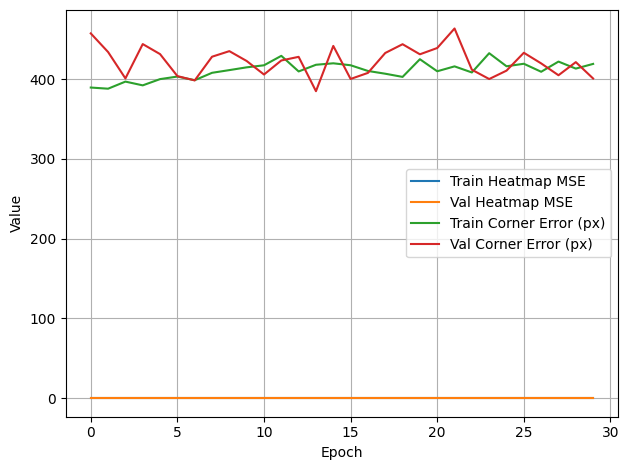

In [2]:
# suppress TF logs
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# install TensorFlow if needed
!pip install -q tensorflow

import json, cv2, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, callbacks
from tqdm.notebook import tqdm

# === Config ===
INPUT_DIR        = "/kaggle/input/mtg-keypoint-regression-dataset-5k"
ANNOTATION_FILE  = os.path.join(INPUT_DIR, "dataset", "dataset", "annotations.json")
IMAGE_DIR        = os.path.join(INPUT_DIR, "dataset", "dataset")
OUTPUT_DIR       = "/kaggle/working"
VISUALIZE_DIR    = os.path.join(OUTPUT_DIR, "training_visualizations")
MODEL_PATH       = os.path.join(OUTPUT_DIR, "mtg_keypoint_heatmap.keras")

IMAGE_SIZE       = 224
HEATMAP_SIZE     = 112
SIGMA_PIXELS     = 2.0
BATCH_SIZE       = 16
EPOCHS           = 30
STEPS_PER_EPOCH  = 200
VALIDATION_STEPS = 50
ORIGINAL_DIM     = 1024

os.makedirs(VISUALIZE_DIR, exist_ok=True)

# GPU info
gpus = tf.config.list_physical_devices('GPU')
print("✅ Using device:", gpus[0].name if gpus else "CPU")

# === Load & filter annotations ===
with open(ANNOTATION_FILE, "r") as f:
    raw = json.load(f)

def valid(a):
    pts = a.get("corners", [])
    return (isinstance(pts, list) and len(pts) == 4 and
            all(isinstance(x, (int,float)) and isinstance(y, (int,float)) and
                0 <= x <= ORIGINAL_DIM and 0 <= y <= ORIGINAL_DIM
                for x,y in pts))

annotations = [a for a in raw if valid(a)]
if not annotations:
    raise RuntimeError("No valid annotations!")
split = int(0.9 * len(annotations))
train_anns, val_anns = annotations[:split], annotations[split:]

# === Precompute grid for heatmaps ===
xs = np.arange(HEATMAP_SIZE)
ys = np.arange(HEATMAP_SIZE)
grid_x, grid_y = np.meshgrid(xs, ys)

def make_heatmaps(corners):
    hm = np.zeros((HEATMAP_SIZE, HEATMAP_SIZE, 4), dtype=np.float32)
    for i, (x_o, y_o) in enumerate(corners):
        x = (x_o / ORIGINAL_DIM) * (HEATMAP_SIZE - 1)
        y = (y_o / ORIGINAL_DIM) * (HEATMAP_SIZE - 1)
        d2 = (grid_x - x)**2 + (grid_y - y)**2
        hm[..., i] = np.exp(-d2 / (2 * SIGMA_PIXELS**2))
    return hm

def data_gen(anns):
    while True:
        imgs = np.zeros((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        hmts = np.zeros((BATCH_SIZE, HEATMAP_SIZE, HEATMAP_SIZE, 4), dtype=np.float32)
        coords = np.zeros((BATCH_SIZE, 4, 2), dtype=np.float32)
        for i in range(BATCH_SIZE):
            a = np.random.choice(anns)
            img = cv2.imread(os.path.join(IMAGE_DIR, a["filename"]))
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)).astype(np.float32) / 255.0
            hm = make_heatmaps(a["corners"])
            imgs[i]   = img
            hmts[i]   = hm
            coords[i] = np.array(a["corners"], dtype=np.float32) / ORIGINAL_DIM
        yield imgs, (hmts, coords)

train_ds = tf.data.Dataset.from_generator(
    lambda: data_gen(train_anns),
    output_signature=(
        tf.TensorSpec((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), tf.float32),
        (tf.TensorSpec((BATCH_SIZE, HEATMAP_SIZE, HEATMAP_SIZE, 4), tf.float32),
         tf.TensorSpec((BATCH_SIZE, 4, 2), tf.float32))
    )
).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: data_gen(val_anns),
    output_signature=(
        tf.TensorSpec((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), tf.float32),
        (tf.TensorSpec((BATCH_SIZE, HEATMAP_SIZE, HEATMAP_SIZE, 4), tf.float32),
         tf.TensorSpec((BATCH_SIZE, 4, 2), tf.float32))
    )
).prefetch(tf.data.AUTOTUNE)

# === Soft‑argmax layer ===
class SoftArgmax(layers.Layer):
    def __init__(self, H, W, **kw):
        super().__init__(**kw)
        xs = tf.linspace(0.0, 1.0, W)
        ys = tf.linspace(0.0, 1.0, H)
        gx, gy = tf.meshgrid(xs, ys)
        self.grid_x = tf.reshape(gx, [-1])
        self.grid_y = tf.reshape(gy, [-1])
        self.H, self.W = H, W

    def call(self, heatmaps):
        B = tf.shape(heatmaps)[0]
        flat = tf.reshape(heatmaps, [B, self.H*self.W, 4])
        probs = tf.nn.softmax(flat, axis=1)
        exp_x = tf.reduce_sum(probs * self.grid_x[None,:,None], axis=1)
        exp_y = tf.reduce_sum(probs * self.grid_y[None,:,None], axis=1)
        return tf.stack([exp_x, exp_y], axis=-1)

# === Build model ===
def build_model():
    inp = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
    base = tf.keras.applications.ResNet50(include_top=False,
                                          input_tensor=inp, weights='imagenet')
    c2 = base.get_layer('conv2_block3_out').output
    c3 = base.get_layer('conv3_block4_out').output
    c4 = base.get_layer('conv4_block6_out').output

    x = layers.Conv2DTranspose(256,3,strides=(2,2),padding='same',activation='relu')(c4)
    x = layers.Concatenate()([x, c3])
    x = layers.Conv2D(256,3,padding='same',activation='relu')(x)
    x = layers.Conv2DTranspose(128,3,strides=(2,2),padding='same',activation='relu')(x)
    x = layers.Concatenate()([x, c2])
    x = layers.Conv2D(128,3,padding='same',activation='relu')(x)
    x = layers.Conv2DTranspose(64,3,strides=(2,2),padding='same',activation='relu')(x)
    feat = layers.Conv2D(64,3,padding='same',activation='relu')(x)

    hm     = layers.Conv2D(4,1,padding='same',activation=None,name='heatmaps')(feat)
    coords = SoftArgmax(HEATMAP_SIZE,HEATMAP_SIZE,name='coords')(hm)

    return models.Model(inputs=inp, outputs=[hm, coords])

model = build_model()

# === Compile ===
def corner_error(y_true, y_pred):
    true_coords = y_true[1]
    err = tf.norm((true_coords - y_pred) * ORIGINAL_DIM, axis=-1)
    return tf.reduce_mean(err)

model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss={'heatmaps':'mse','coords':'mse'},
    loss_weights={'heatmaps':1.0,'coords':0.0},
    metrics={'coords':corner_error}
)

# === Callbacks ===
class TQDM_CB(callbacks.Callback):
    def on_epoch_begin(self, ep, logs=None):
        self.bar = tqdm(total=STEPS_PER_EPOCH, desc=f"Epoch {ep+1}/{EPOCHS}", leave=False)
    def on_batch_end(self, batch, logs=None):
        self.bar.update(1)
    def on_epoch_end(self, ep, logs=None):
        self.bar.close()
        print(f"✅ Epoch {ep+1} — "
              f"loss={logs['loss']:.4f}, "
              f"val_loss={logs['val_loss']:.4f}, "
              f"val_corner_error={logs['val_coords_corner_error']:.1f}px")

class VisCB(callbacks.Callback):
    def on_epoch_end(self, ep, logs=None):
        a = np.random.choice(val_anns)
        img = cv2.imread(os.path.join(IMAGE_DIR, a["filename"]))
        vis = cv2.resize(img, (ORIGINAL_DIM, ORIGINAL_DIM))
        inp = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)).astype(np.float32)/255.0
        hm_pred, coords_pred = model.predict(inp[None])
        for x,y in coords_pred[0]:
            cv2.circle(vis,(int(x*ORIGINAL_DIM),int(y*ORIGINAL_DIM)),6,(0,0,255),-1)
        for x,y in a["corners"]:
            cv2.circle(vis,(int(x),int(y)),6,(0,255,0),-1)
        cv2.imwrite(os.path.join(VISUALIZE_DIR,f"epoch_{ep+1:02d}.jpg"),vis)

# === Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    callbacks=[TQDM_CB(), VisCB(),
               callbacks.ReduceLROnPlateau(patience=3,factor=0.5),
               callbacks.ModelCheckpoint(MODEL_PATH,save_best_only=True,monitor='val_coords_corner_error')],
    verbose=0
)

# === Plot training curves ===
plt.figure()
plt.plot(history.history['heatmaps_loss'],            label='Train Heatmap MSE')
plt.plot(history.history['val_heatmaps_loss'],        label='Val Heatmap MSE')
plt.plot(history.history['coords_corner_error'],      label='Train Corner Error (px)')
plt.plot(history.history['val_coords_corner_error'],  label='Val Corner Error (px)')
plt.legend(); plt.grid(True)
plt.xlabel('Epoch'); plt.ylabel('Value')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "training_curves_heatmap.png"))

print("✅ Training complete — curves & visualizations saved.")


## Convert to tensorflowjs for use on the web:

In [3]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 whic

### Convert the Keras model to tfjs graph model for use on the web:

In [20]:
#!/usr/bin/env python
# convert_to_tfjs_graph.py

import os
import shutil
import tensorflow as tf

# ─── CONFIG ──────────────────────────────────────────────────────────────────────
KERAS_MODEL_FILE = "/kaggle/working/mtg_keypoint_heatmap.keras" # wherever we saved the keras model
TMP_SAVED_MODEL  = "/kaggle/working/tmp_saved_model"    # temp export
TFJS_OUT_DIR     = "/kaggle/working/web_model"          # this should map to public/web_model

# ─── CLEAN ───────────────────────────────────────────────────────────────────────
if not os.path.isfile(KERAS_MODEL_FILE):
    raise FileNotFoundError(f"Keras model not found at {KERAS_MODEL_FILE}")
shutil.rmtree(TMP_SAVED_MODEL, ignore_errors=True)
shutil.rmtree(TFJS_OUT_DIR, ignore_errors=True)
os.makedirs(TMP_SAVED_MODEL, exist_ok=True)
os.makedirs(TFJS_OUT_DIR, exist_ok=True)

# ─── REGISTER YOUR CUSTOM LAYER ─────────────────────────────────────────────────
@tf.keras.utils.register_keras_serializable()
class SoftArgmax(tf.keras.layers.Layer):
    def __init__(self, H, W, **kwargs):
        super().__init__(**kwargs)
        xs = tf.linspace(0.0, 1.0, W)
        ys = tf.linspace(0.0, 1.0, H)
        gx, gy = tf.meshgrid(xs, ys)
        # flatten ahead of time
        self.grid_x = tf.reshape(gx, [-1])
        self.grid_y = tf.reshape(gy, [-1])
        self.H, self.W = H, W

    def call(self, heatmaps):
        B = tf.shape(heatmaps)[0]
        K = tf.shape(heatmaps)[-1]
        flat = tf.reshape(heatmaps, [B, self.H * self.W, K])
        probs = tf.nn.softmax(flat, axis=1)
        exp_x = tf.reduce_sum(probs * self.grid_x[None, :, None], axis=1)
        exp_y = tf.reduce_sum(probs * self.grid_y[None, :, None], axis=1)
        return tf.stack([exp_x, exp_y], axis=-1)

# ─── LOAD & EXPORT SAVEDMODEL ─────────────────────────────────────────────────
print("⏳ Loading Keras model…")
model = tf.keras.models.load_model(
    KERAS_MODEL_FILE,
    compile=False,
    custom_objects={'SoftArgmax': SoftArgmax}
)
print("✅ Loaded. Exporting SavedModel to:", TMP_SAVED_MODEL)
tf.saved_model.save(model, TMP_SAVED_MODEL)

# ─── CONVERT TO TFJS GRAPHMODEL ────────────────────────────────────────────────
# Make sure `tensorflowjs` is installed (`pip install tensorflowjs`)
cmd = (
    "tensorflowjs_converter "
    "--input_format=tf_saved_model "
    "--output_format=tfjs_graph_model "
    "--signature_name=serving_default "
    f"{TMP_SAVED_MODEL} "
    f"{TFJS_OUT_DIR}"
)
print("⏳ Running:\n", cmd)
res = os.system(cmd)
if res != 0:
    raise RuntimeError(f"tensorflowjs_converter failed (exit code {res})")

print("✅ TFJS GraphModel ready in:", TFJS_OUT_DIR)

⏳ Loading Keras model…
✅ Loaded. Exporting SavedModel to: /kaggle/working/tmp_saved_model
⏳ Running:
 tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model --signature_name=serving_default /kaggle/working/tmp_saved_model /kaggle/working/web_model


E0000 00:00:1744931810.737237     251 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744931810.744852     251 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
I0000 00:00:1744931821.766029     251 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1744931821.766407     251 single_machine.cc:361] Starting new session


✅ TFJS GraphModel ready in: /kaggle/working/web_model


### Zip up the Final contents for use on the web:

In [21]:
# Cell: Zip up the TFJS `web_model` directory for download
import shutil
import os

# Paths
web_model_dir = os.path.join('/kaggle/working', 'web_model')
zip_path = os.path.join('/kaggle/working', 'web_model')

# Create ZIP archive (will produce /kaggle/working/web_model.zip)
shutil.make_archive(zip_path, 'zip', web_model_dir)

print(f"✅ Created archive: {zip_path}.zip")


✅ Created archive: /kaggle/working/web_model.zip
